# Miquel Monge Dalmau
---



---


# Convolutional Neural Networks for Object Localization

In this notebook we will learn how to implement a convolutional neural network (CNN) regressor to localize objects of the FashionMNIST dataset. We will use the Pytorch library for the implementation, compilation and training of the model.

The input to our model is a $64 \times 64$ image with a FashionMNIST object at any location, and the output of the model are four real numbers that define a bounding box (x, y, width, and height) around the object.

> Agafarem les imatges de MNIST (estan molt ben centrades), el nostre dataset seran imatge 64x64 que tindràn enganxades en algun lloc random alguna imatge de MNIST. El model dirà on està i quina és la classe de l'objecte.

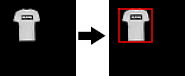

### Import necessary modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

from torchsummary import summary

print('Check GPU runtime type... ')
use_cuda = torch.cuda.is_available()
if not use_cuda:
  device = "cpu"
  print('Change Runtype Type in top menu for GPU acceleration')
else:
  device = "cuda"
  print('OK!')

Check GPU runtime type... 
OK!


## Create a custom dataset

First of all we need a custom dataset class to create our training/test samples. This class creates synthetic images by placing FashionMNIST objects (wich have a size $28 \times 28$) at random locations of a black $64 \times 64$ canvas image.

> Necessitem el constructor, el gettitem (mètode que cridem és com un iterable) retornarem la imatge i el seu groundtrough (4 nombres de bounidng box).

> Fer servir randoms pel test set és un error, al constructor hauríem de veure si estem en test set, i que els valors en aquest cas estiguin fixes.

In [ ]:
class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True) # càrreguem el MNIST amb les transformacions com a pàrametre

    def __len__(self):
        return self.fashionMnist.data.shape[0] # num d'exemples del dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize)
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:]

        # Get label of the image
        label_img = self.fashionMnist.targets[idx]

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform:
            image = self.transform(image)

        # normalize the target values (bounding box coordinates) so they are real numbers from 0. to 1.
        # per poder reutilitzar la xarxa per altres imatges, utilitzem coordenades relatives (no pixels d'imatge)
        bbox = np.array([x_offset / image_width, y_offset / image_height, 
                         object_width / image_width, object_height / image_height], dtype=np.float32)
            
        sample = {'image': image, 'bbox': bbox, 'cls': label_img}

        return sample

Now we can create the necessary Dataset and DataLoader objects as follows.

In [ ]:
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Dataset de entrenament i validació
dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform)
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



### Visualize some generated samples

0 torch.Size([1, 64, 64]) (4,)
1 torch.Size([1, 64, 64]) (4,)
2 torch.Size([1, 64, 64]) (4,)
3 torch.Size([1, 64, 64]) (4,)


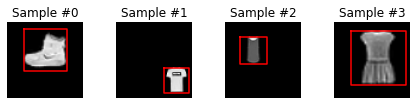

In [ ]:
def show_bbox(image, bbox, pred=None):
    """Show image with bounding box - podem passar 2 bbox (predicció i groundtruth"""
    image = image.squeeze()
    plt.imshow(image, cmap='gray')

    # plot the ground truth bounding box
    imgsize = image.shape
    bbox *= [imgsize[1],imgsize[0],imgsize[0],imgsize[1]]
    plt.plot([bbox[0],bbox[0]+bbox[2],bbox[0]+bbox[2],bbox[0],bbox[0]],
             [bbox[1],bbox[1],bbox[1]+bbox[3],bbox[1]+bbox[3],bbox[1]], c='r')

    if pred is not None: 
        # plot the predicted bounding box (if provided)
        pred *= [imgsize[1],imgsize[0],imgsize[0],imgsize[1]]
        plt.plot([pred[0],pred[0]+pred[2],pred[0]+pred[2],pred[0],pred[0]],
                 [pred[1],pred[1],pred[1]+pred[3],pred[1]+pred[3],pred[1]], c='b')
    
    
 
fig = plt.figure()
for i in range(len(dataset1)):
    sample = dataset1[i]
    print(i, sample['image'].shape, sample['bbox'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbox(sample['image'], sample['bbox'])

    if i == 3:
        plt.show()
        break

In [ ]:
# check the size of the dataset
print("Size of training data: {}".format(len(dataset1)))
print("Size of test data: {}".format(len(dataset2)))

Size of training data: 60000
Size of test data: 10000


We have 60,000 images for training and 10,000 for testing. The image size is $64 \times 64$ pixels and they have only one channel (greyscale images).

## Create the CNN regression model

We will use a simple CNN model with four convolutional layers, one pooling layer, and two fully connected layers. 

Notice that the output layer has four neurons with a `sigmoid` activation, so our model produces at its outputs four real numbers (x, y, width, and height).

**Question: Why are we using a `sigmoid` activation? Can we use other activation functions in this model?**

**Apunts de classe**

> Ara fem la regressió, no fem la classificació. Tenim 2 blocs seqüencials: backbone amb a() Relus i l'altre és la sortida de la bbox, capa lineal amb a() sigmoide. A forward, passa per convolucionals, fa un feature extractor, la feature és la que processem amb la capa lineal amb els 4 nombres de bbox. Si volem afegir classificació necessitem un bloc més:

> self.classification = nn.Sequential(capes lineals (una o més)) però ara no són 4 sortides, ara seran tantes sortides com classes (10). softmax per classificar.

> volem treure noms reals no una sortida amb 0 i 1, perquè és una regressió. Sabem que la sortida estan acotades entre 0 i 1, per això posem sigmoide, també podem posar una lineal (-inf a inf) però pot ser que a la xarxa li costi més trobar el rang. Amb sigmoide li diem que els valors que estem buscant estan entre 0 i 1. També podem posar una tanh, una relu (valors entre o i +inf).

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          )
        
        self.bbox = nn.Sequential(nn.Linear(32,4), nn.Sigmoid())
        
    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox(features)
        return bbox

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 4]             132
          Sigmoid-12                    [-1, 4]               0
Total params: 15,396
Trainable params: 15,396
Non-trainable params: 0
---------------------------------

> Mètode summary a partir d'una imatge 64x64 veiem com passaria a la xarxa.

### Define the training method

For training our CNN regression model we will use the L1 loss, which takes the mean element-wise absolute value difference.

See <a href="https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss">`torch.nn.L1Loss`</a> for details.

> Fem servir loss de regressió, normalment fem servir crossentropy. MSE també ens serviria.

In [ ]:
def train(model, device, train_loader, optimizer, epoch, mode = 'cls', scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target = sample_batched['bbox']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output, target) if mode == 'reg' else F.cross_entropy(output, target) # depenent si fem reg o cls canviarà el loss
        loss_values.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None:
            scheduler.step()
    return loss_values

### Train the model

We will train the model with the [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) and the [`OneCycleLR`](https://pytorch.org/docs/stable/optim.html?highlight=onecyclelr#torch.optim.lr_scheduler.OneCycleLR) learning rate scheduler.

>  **OneCycleLR**: pirmer incrementem fins a valor màxim i dp anem reduïnt. No hi ha cap raó per utilitxar aquest i no altres, normalment es fa servir a problemes més fidicils.

In [ ]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

log_interval = 100 # how many batches to wait before logging training status

loss_history_reg = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, 'reg', scheduler)
    loss_history_reg += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.184809
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.097225
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.091650
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.074382
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.061195
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.067465
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.052937
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.055076
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.057057
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.064893
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.043101
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.041905
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.039127
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.035439
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.029305
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.038067
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.038082
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.028179
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.021616
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.024147
Train Epoch:

### Plot the loss over time

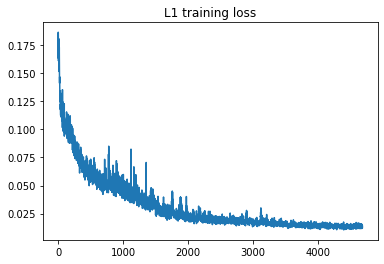

In [ ]:
plt.plot(np.arange(len(loss_history_reg)), loss_history_reg)
plt.title('L1 training loss')
plt.show()

## Evaluate the model

Finally, we can use the trained model to predict a bounding box for any given image. Let's see how to make predictions for the first four images of the test set.

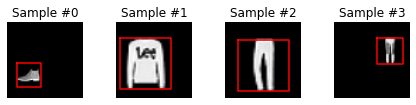

In [ ]:
model.eval()

fig = plt.figure()
for i in range(len(dataset2)):
    sample = dataset2[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        
    sample['pred'] = output[0].cpu().numpy()
    show_bbox(sample['image'], sample['bbox'])

    if i == 3:
        plt.show()
        break

We appreciate that the predicted bounding boxes (blue) are usually good aproximations of the ground truth (red).

In order to measure whether the results are correct or not in the entire test set we need to implement a performance measure based on the Intersection over Union (IoU) of the ground truth and predicted bounding boxes.

<table>
<tr>
<td><img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_stop_sign.jpg" width=50%></td>
<td><img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png" width=50%></td>
</tr>
<tr>
<td colspan=2><div style="font-size:3">Images from: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/</div></td>
</tr>
</table>


> Direm que la predicció és correcte en cas que la iou de la bbox i la predicció sigui més gran a un threshold, retorna un array de boleans dels casos que es compleix.

In [ ]:
def IoU(pred, target, iou_threshold = 0.7):
    # determine the coordinates of the intersection rectangle
    x_left = np.maximum(pred[:,0], target[:,0])
    y_top = np.maximum(pred[:,1], target[:,1])
    x_right = np.minimum(pred[:,0]+pred[:,2], target[:,0]+target[:,2])
    y_bottom = np.minimum(pred[:,1]+pred[:,3], target[:,1]+target[:,3])
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the areas of the union
    pred_area = pred[:,2] * pred[:,3]
    target_area =  target[:,2] *  target[:,3]
    
    union_area = pred_area + target_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou>iou_threshold

### Define the test method

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target = sample_batched['bbox']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.l1_loss(output, target).item()
            
            # count the number of prediction with an IoU above a certain threshold
            correct += np.sum(IoU(output.cpu().numpy(), target.cpu().numpy(), iou_threshold = 0.65))

    test_loss /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)


Test set: Average loss: 0.0135, Accuracy: 9924/10000 (99%)



> El nombre accuracy podria variar, i per això hem explicat a l'inici de la pràctica. Per solucionar-ho, hauríem de modificar la classe on creem el custom dataset, en aquest cas, podem ser tolerants i no passaria res si l'accuracy varia una miqueta en diferents execucions. Si volguéssim aplicar els coneixements d'aquesta pràctica a altres més crítiques, seria recomanable arreglar aquest error.

It usually a good idea to manually inspect the errors of the model in order to figure out when it is not working well.

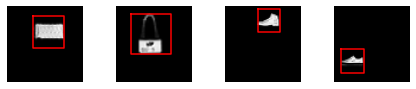

In [ ]:
# Find wrong prediction and display it

model.eval()

count = 0

for i in range(len(dataset2)):
    sample = dataset2[i]
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
    
    target = sample['bbox'].reshape((1,4))
    iou= IoU(output.cpu().numpy(), target, iou_threshold = 0.7)
    
    if not iou:
        #print(output.cpu().numpy(), target,iou)
        ax = plt.subplot(1, 4, count + 1)
        plt.tight_layout()
        ax.axis('off')
        sample['pred'] = output[0].cpu().numpy()
        show_bbox(sample['image'], sample['bbox'])
        count += 1
           
    if count == 4:
        plt.show()
        break

> Veiem que si som més flexibles amb el llindar la xarxa ho fa bastant bé. Fa la impressió que tenim més error amb imatges més petites.


## HOMEWORK

**A)** Create a CNN model for classification and train it on our synthetic dataset for 5 epochs. For this you must create a new Dataset class that produces the ground truth class labels for classification instead of the bounding box annotations as we did in the `FashionMNISTlocalizationDataset` class.

In [ ]:
def train(model, device, train_loader, optimizer, epoch, mode = 'cls', scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']                                              # ground truth for regression
        target = sample_batched['bbox'] if mode == 'reg' else sample_batched['cls'] # ground truth class labels for classification

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output, target) if mode == 'reg' else F.cross_entropy(output, target) # depenent si fem reg o cls canviarà el loss
        loss_values.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None:
            scheduler.step()
    return loss_values

In [ ]:
class CLS(nn.Module):
    def __init__(self):
        super(CLS, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          )
        
        # Agefim classificació, tenim 10 classes
        self.classifier = nn.Linear(32, 10)
  
        
    def forward(self, x):
        features = self.backbone(x)
        cls = self.classifier(features)
        return cls

summary(CLS(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 15,594
Trainable params: 15,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/ba

> El classificador és molt simple, podríem arribar a complicar-lo tant com volguéssim, per exemple, utilitzant models que hem vist en anteriors pràctiques (Alexnet, VG, etc), així i tot, com la tasca de classificació és senzilla, amb el que hem fet hauria de ser suficient.

In [ ]:
model = CLS().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

log_interval = 100 # how many batches to wait before logging training status

loss_history_cls = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, 'cls', scheduler)
    loss_history_cls += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307965
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.310452
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.020543
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.618694
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.360551
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.976940
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.161664
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.804607
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.952730
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.838891
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.656632
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.763503
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.831235
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.868269
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.827940
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.626306
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.685760
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.593348
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.659517
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.680421
Train Epoch:

**B)** Plot the training loss curves of the regression model and the classification model in the same figure. We want to compare the two loss curves, so it is important to plot them in the same figure and to set up a legend for the plot. This figure is very important because it will give you a hint for the next exercise.

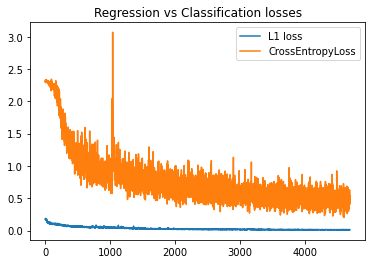

In [ ]:
plt.plot(loss_history_reg, label = "L1 loss")
plt.plot(loss_history_cls, label = "CrossEntropyLoss")
plt.legend()
plt.title('Regression vs Classification losses')
plt.show()

> Model optim primera xarxa fa proposta de regió. Aqui no ho fem així, per tant dificulta la tasca de clasificació.

**C)** Modify the regression model adding a classification output, so that it can jointly predict the bounding box of the object and also its class label. This implies you will need to modify: the model (it must have two separate outputs), the Dataset class (to produce the ground truth class label AND the bounding box coordinates), and your training method by adding a new loss that combines a regression loss and a classification loss. Think about how to combine these two losses in a single cost function to be optimized. Hint: look at the figure of exercise (B).

> La pista la dona el plot de l'exercici anterior.

> Ara voldrem fusionar les dues xarxes, la de regressió i la de classificació. Amb les sortides corresponents:
opcions:

- loss = a x LossReg + b x LossClass

In [ ]:
class CLS(nn.Module):
    def __init__(self):
        super(CLS, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          )
        
        # Agefim classificació, tenim 10 classes
        self.classifier = nn.Linear(32, 10)
    
        # Afegim la regressió
        self.bbox = nn.Sequential(
          nn.Linear(32, 4),
          nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.backbone(x)
        out = self.classifier(features)
        bbox = self.bbox(features)

        return out, bbox

summary(CLS(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
           Linear-12                    [-1, 4]             132
          Sigmoid-13                    [-1, 4]               0
Total params: 15,726
Trainable params: 

In [ ]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None, a = 0.1, b = 2.5):
    model.train()
    loss_values = []
    loss_values_reg = []
    loss_values_cls = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target_reg = sample_batched['bbox']
        target_cls = sample_batched['cls']

        data, target_reg, target_cls = data.to(device), target_reg.to(device), target_cls.to(device)
        optimizer.zero_grad()
        output_cls, output_reg = model(data)
        loss_reg = F.l1_loss(output_reg, target_reg)
        loss_cls = F.cross_entropy(output_cls, target_cls)
        loss = a*loss_cls + b*loss_reg # ponderamos los pesos para darle igual importancia

        loss_values.append(loss.detach().cpu())
        loss_values_cls.append(loss_cls.detach().cpu())
        loss_values_reg.append(loss_reg.detach().cpu())

        loss.backward()   # backward sobre la loss ponderada
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss_cls: {:.6f} \tLoss_reg: {:.6f}\tTotal_loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_cls.item(),loss_reg.item(),loss.item()))
        if scheduler is not None:
            scheduler.step()
    return loss_values, loss_values_cls, loss_values_reg

In [ ]:
model = CLS().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

log_interval = 100 # how many batches to wait before logging training status

combination_loss_history = []
combination_loss_cls = []
combination_loss_reg = []
for epoch in range(1, epochs + 1):
    loss_values, loss_values_cls, loss_values_reg = train(model, device, train_loader, optimizer, epoch, scheduler)
    combination_loss_history += loss_values
    combination_loss_cls += loss_values_cls
    combination_loss_reg += loss_values_reg

Train Epoch: 1 [0/60000 (0%)]		Loss_cls: 2.307560 	Loss_reg: 0.180859	Total_loss: 0.682903
Train Epoch: 1 [6400/60000 (11%)]		Loss_cls: 2.308008 	Loss_reg: 0.099283	Total_loss: 0.479009
Train Epoch: 1 [12800/60000 (21%)]		Loss_cls: 2.240889 	Loss_reg: 0.092946	Total_loss: 0.456454
Train Epoch: 1 [19200/60000 (32%)]		Loss_cls: 2.170227 	Loss_reg: 0.074666	Total_loss: 0.403687
Train Epoch: 1 [25600/60000 (43%)]		Loss_cls: 2.130913 	Loss_reg: 0.064357	Total_loss: 0.373983
Train Epoch: 1 [32000/60000 (53%)]		Loss_cls: 1.909850 	Loss_reg: 0.053608	Total_loss: 0.325006
Train Epoch: 1 [38400/60000 (64%)]		Loss_cls: 1.495043 	Loss_reg: 0.049166	Total_loss: 0.272418
Train Epoch: 1 [44800/60000 (75%)]		Loss_cls: 1.354784 	Loss_reg: 0.041031	Total_loss: 0.238055
Train Epoch: 1 [51200/60000 (85%)]		Loss_cls: 1.150194 	Loss_reg: 0.053359	Total_loss: 0.248416
Train Epoch: 1 [57600/60000 (96%)]		Loss_cls: 1.061172 	Loss_reg: 0.042308	Total_loss: 0.211886
Train Epoch: 2 [0/60000 (0%)]		Loss_cls: 0.997

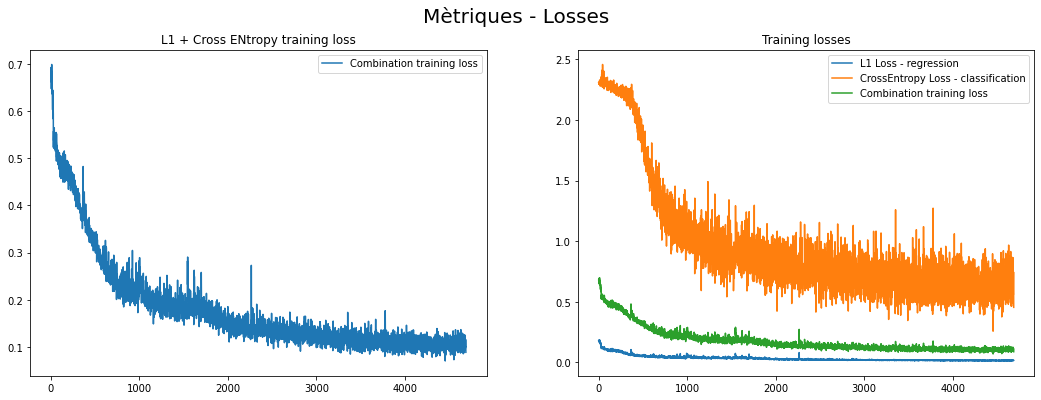

In [ ]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))


ax1.plot(combination_loss_history, label= "Combination training loss")
ax1.set_title("L1 + Cross ENtropy training loss")
ax1.legend()

ax2.plot(combination_loss_reg, label= "L1 Loss - regression")
ax2.plot(combination_loss_cls, label= "CrossEntropy Loss - classification")
ax2.plot(combination_loss_history, label= "Combination training loss")
ax2.set_title("Training losses")
ax2.legend()


fig.suptitle("Mètriques - Losses", fontsize = 20)
plt.show()  

**D)** Evaluate the trained model for the joint classification and localization task. You must modify the test method to count a given prediction as correct if it correctly localizes the object AND predicts the correct label.

In [ ]:
def test(model, device, test_loader, a = 0.1, b = 2.5):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target_reg = sample_batched['bbox']
            target_cls = sample_batched['cls']

            data, target_reg, target_cls = data.to(device), target_reg.to(device), target_cls.to(device)
            output_cls, output_reg = model(data)
            test_loss_cls = F.cross_entropy(output_cls, target_cls).item()
            test_loss_reg = F.l1_loss(output_reg, target_reg).item()
            test_loss += (a*test_loss_cls + b*test_loss_reg)
            
            correct_bb = IoU(output_reg.cpu().numpy(), target_reg.cpu().numpy(), iou_threshold = 0.5)
            for i in range(len(correct_bb)):
              if correct_bb[i] and torch.argmax(output_cls[i].cpu()) == target_cls[i].cpu():
                  correct += 1

    test_loss /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)


Test set: Average loss: 0.1065, Accuracy: 7462/10000 (75%)



**E)** (OPTIONAL EXERCISE) Modify the model so it can also detect if an input image contains no object. For this you must add another regression output for the digit confidence (a value between 0. and 1. indicating the presence of an object). This implies you will need to modify the Dataset class to generate images without digits. Also, during training you must take care of not backpropagating the bounding box and classification losses when there is no digit. 

To make the problem more difficult and interesting we can add some noise to the images and see how the performance of the model drops. See [this link](https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745) on how to create a custom transform for adding random noise on images.

Use `matplotlib.pyplot.boxplot` to visualize the average confidence per class before and after adding noise to the images.

In [ ]:
from random import randint, seed
seed(2)


class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True) # càrreguem el MNIST amb les transformacions com a pàrametre

    def __len__(self):
        return self.fashionMnist.data.shape[0] # num d'exemples del dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize)
        image_width, image_height = self.imgsize
        
        prob_img_with_digits = randint(0, 100)
        if (prob_img_with_digits) > 80:
            # Get one Fashion-MNIST object, resize it randomly, and copy it into
            # a random location of the black image
            object_img = self.fashionMnist.data[idx,:,:]

            # Get label of the image
            label_img = self.fashionMnist.targets[idx]

            object_width  = object_height = np.random.randint(19,47)

            object_img = resize(object_img, (object_height, object_width))

            x_offset = np.random.randint(0,image_width-object_width)
            y_offset = np.random.randint(0,image_height-object_height)

            image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
            
            image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
            
            if self.transform:
                image = self.transform(image)

            # normalize the target values (bounding box coordinates) so they are real numbers from 0. to 1.
            # per poder reutilitzar la xarxa per altres imatges, utilitzem coordenades relatives (no pixels d'imatge)
            bbox = np.array([x_offset / image_width, y_offset / image_height, 
                            object_width / image_width, object_height / image_height], dtype=np.float32)

        else:
            # Image without digits
            bbox = np.array([0,0,0,0], dtype=np.float32)
            label_img = torch.tensor(0)
              
        sample = {'image': image, 'bbox': bbox, 'cls': label_img}

        return sample

In [ ]:
# Add random noise to images
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform = transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomApply([AddGaussianNoise(0., 1.)], p = 0.5)
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform)
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

In [ ]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values = []
    loss_values_reg = []
    loss_values_cls = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target_reg = sample_batched['bbox']
        target_cls = sample_batched['cls']

        data, target_reg, target_cls = data.to(device), target_reg.to(device), target_cls.to(device)
        optimizer.zero_grad()
        output_cls, output_reg = model(data)
        loss_reg = F.l1_loss(output_reg, target_reg)
        loss_cls = F.cross_entropy(output_cls, target_cls)
        loss = 0.1*loss_cls + 0.9*loss_reg #ponderamos los pesos para darle igual importancia

        loss_values.append(loss.detach().cpu())
        loss_values_cls.append(loss_cls.detach().cpu())
        loss_values_reg.append(loss_reg.detach().cpu())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss_cls: {:.6f} \tLoss_reg: {:.6f}\tTotal_loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_cls.item(),loss_reg.item(),loss.item()))
        if scheduler is not None:
            scheduler.step()
    return loss_values, loss_values_cls, loss_values_reg